## Assignment_2

**Steps:**

1. Declustered spatial well data (Cell Declustering) 
2. Tested signiﬁcance of diﬀerence in mean porosity and permeability between the facies (Hypothesis Testing)
3. Reevaluated univariate statistics based on declustered data
4. Assessed heterogeneity in the reservoir (Coeﬃcient of variation, Dykstra-Parsons, and Lorenz). 
5. Developed initial uncertainty model of porosity and permeability (Bootstrap) 
6. Estimated facies proportions and oil in place (Bootstrap)
7. Assessed impact of 10 additional wells on the uncertainty model
8. Conclusions


In [1]:
# importing
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
from mpl_toolkits.mplot3d.axes3d import Axes3D
import geostatspy.GSLIB as GSLIB
import geostatspy.geostats as geostats
import scipy.stats as st
import seaborn as sns
import math
import random
from scipy import stats

### 1. Declustered spatial well data (Cell Declustering)

In [2]:
# loading data
sd = pd.read_csv("Data/1_sample_data.csv")
sandstone_raw = sd.loc[(sd['Facies'] == 1)] # Group by facies (Sandstone)
shale_raw = sd.loc[(sd['Facies'] == 0)] # Group by facies (Shale)
seismic = np.loadtxt("Data/1_AI.csv", delimiter=",")
sandstone = pd.read_csv("Data/Sandstone_cleaned.csv")
shale = pd.read_csv("Data/Shale_cleaned.csv")
df_clean = pd.concat([shale, sandstone], axis=0)
del df_clean['Unnamed: 0']
del df_clean['Unnamed: 0.1']

**1.1 Performing Cell Declustering on porosity data (outliers removed) both facies included**

In [3]:
wts, cell_sizes, dmeans = geostats.declus(df_clean,'X','Y','Porosity',iminmax = 1, noff= 10, ncell=100,cmin=10,cmax=1000)
df_clean['Wts'] = wts                            # add weights to the sample data DataFrame
df_clean.head()                                  # preview to check the sample data DataFrame

There are 217 data with:
   mean of      0.13536741338554406 
   min and max  0.0606929054762965 and 0.20438817014234475
   standard dev 0.024034484994892254 


,X,Y,Facies,Porosity,Perm,AI,Wts
0,80.0,280.0,0.0,0.102919,0.196018,6753.323723,1.120736
1,160.0,840.0,0.0,0.128852,0.673043,6068.296567,0.920619
2,160.0,760.0,0.0,0.103365,5.368073,5574.433666,0.786815
3,160.0,120.0,0.0,0.142252,5.189214,7330.542384,2.111843
4,320.0,120.0,0.0,0.135132,1.850340,5501.993421,0.854673


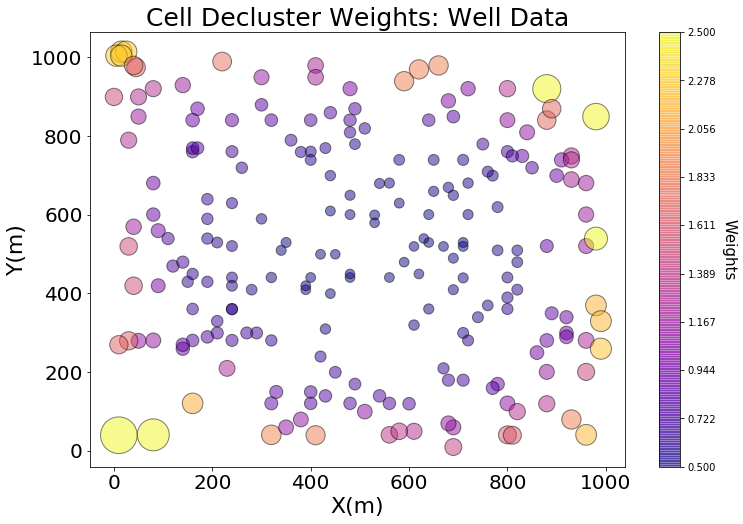

In [4]:
# plotting it my way - scaling point size by weight as well as using color
vmin = 0.5; vmax = 2.5;   # range of porosity values
plt.figure(figsize=(12,8))
im = plt.scatter(df_clean['X'],df_clean['Y'],s=200*df_clean['Wts'],c=df_clean['Wts'],marker=None,cmap=plt.cm.plasma,norm=None,vmin=vmin,vmax=vmax,alpha=0.5,verts=None,edgecolors="black")
plt.title('Cell Decluster Weights: Well Data', size=25)
plt.xlabel('X(m)', size=22)
plt.xticks(fontsize=20)
plt.ylabel('Y(m)', size=22)
plt.yticks(fontsize=20)
cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
cbar.set_label('Weights',rotation=270,labelpad=20,size=15)
plt.show()

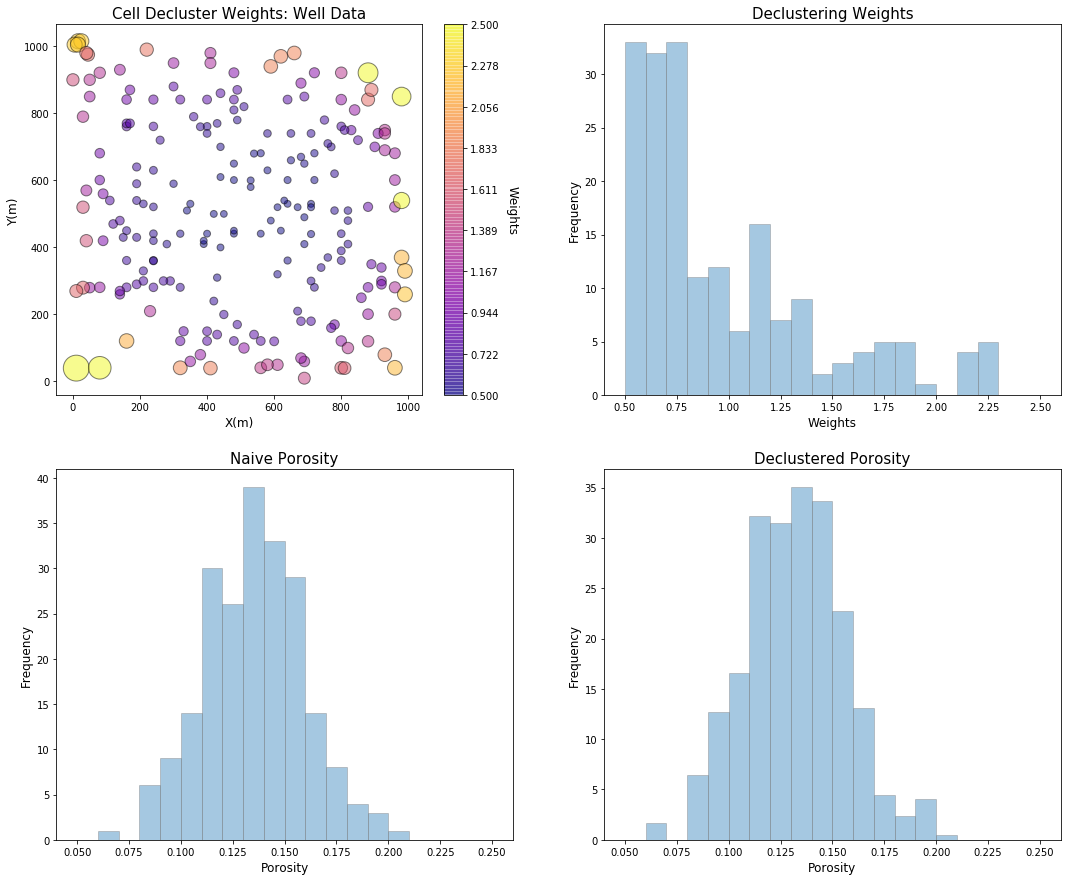

In [5]:
# Plotting histograms with map of decluster weights
plt.figure(figsize=(18,15))

plt.subplot(221)
vmin = 0.5; vmax = 2.5;   # range of porosity values
im = plt.scatter(df_clean['X'],df_clean['Y'],s=100*df_clean['Wts'],c=df_clean['Wts'],marker=None,cmap=plt.cm.plasma,norm=None,vmin=vmin,vmax=vmax,alpha=0.5,verts=None,edgecolors="black")
plt.title('Cell Decluster Weights: Well Data', size=15)
plt.xlabel('X(m)', size=12)
plt.xticks(fontsize=10)
plt.ylabel('Y(m)', size=12)
plt.yticks(fontsize=10)
cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
cbar.set_label('Weights',rotation=270,labelpad=20,size=12)

plt.subplot(222)
whist = plt.hist(df_clean['Wts'],edgecolor='gray',bins=20,alpha=0.4,range=[vmin,vmax])
plt.title('Declustering Weights', size=15)
plt.xlabel('Weights',size=12)
plt.ylabel('Frequency',size=12)

plt.subplot(223)
naivehist = plt.hist(df_clean['Porosity'],edgecolor='gray',bins=20,alpha=0.4,range=[vmin/10,vmax/10])
plt.title('Naive Porosity',size=15)
plt.xlabel('Porosity',size=12)
plt.ylabel('Frequency',size=12)

plt.subplot(224)
decluhist = plt.hist(df_clean['Porosity'],edgecolor='gray',bins=20,alpha=0.4,range=[vmin/10,vmax/10],weights=df_clean['Wts'])
plt.title('Declustered Porosity',size=15)
plt.xlabel('Porosity',size=12)
plt.ylabel('Frequency',size=12)

plt.show()

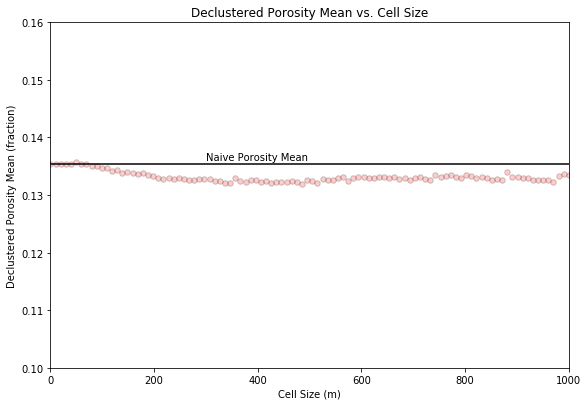

In [6]:
# decluster mean v cell size
por_mean = np.average(df_clean['Porosity'].values)
plt.subplot(111)
plt.scatter(cell_sizes,dmeans, s=30, alpha = 0.2, edgecolors = "black", facecolors = 'red')
plt.xlabel('Cell Size (m)')
plt.ylabel('Declustered Porosity Mean (fraction)')
plt.title('Declustered Porosity Mean vs. Cell Size')
plt.plot([0,1000],[por_mean,por_mean],color = 'black')
plt.text(300., 0.136, r'Naive Porosity Mean')
plt.ylim(0.10,0.16)
plt.xlim(0,1000)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

In [7]:
# find index of minimum declustered value and get corresponding cell size
min_dmeans = dmeans.min()
min_location = np.where(dmeans == min_dmeans)
min_cell = cell_sizes[min_location[0][0]]
print("Minimum value: " + str(min_dmeans))
print("Corresponding cell size: " + str(min_cell))

Minimum value: 0.13196868224103886
Corresponding cell size: 485.19999999999953


For a field with dimensions 1000m x 1000m, choosing a cell size of 500m feels too large to me. Maybe a lower value of 200m or 250m is more appropriate.

**1.2 Cell declustering on shale porosity values (outliers removed)**

In [8]:
wts, cell_sizes, dmeans = geostats.declus(shale,'X','Y','Porosity',iminmax = 1, noff= 10, ncell=100,cmin=10,cmax=1000)
shale['Wts'] = wts                            # add weights to the sample data DataFrame
shale.head()                                  # preview to check the sample data DataFrame

There are 53 data with:
   mean of      0.11501478234971194 
   min and max  0.0606929054762965 and 0.16093715216411694
   standard dev 0.020763656808223074 


,Unnamed: 0,Unnamed: 0.1,X,Y,Facies,Porosity,Perm,AI,Wts
0,3,8,80.0,280.0,0.0,0.102919,0.196018,6753.323723,1.0
1,5,13,160.0,840.0,0.0,0.128852,0.673043,6068.296567,1.0
2,6,14,160.0,760.0,0.0,0.103365,5.368073,5574.433666,1.0
3,10,22,160.0,120.0,0.0,0.142252,5.189214,7330.542384,1.0
4,20,46,320.0,120.0,0.0,0.135132,1.850340,5501.993421,1.0


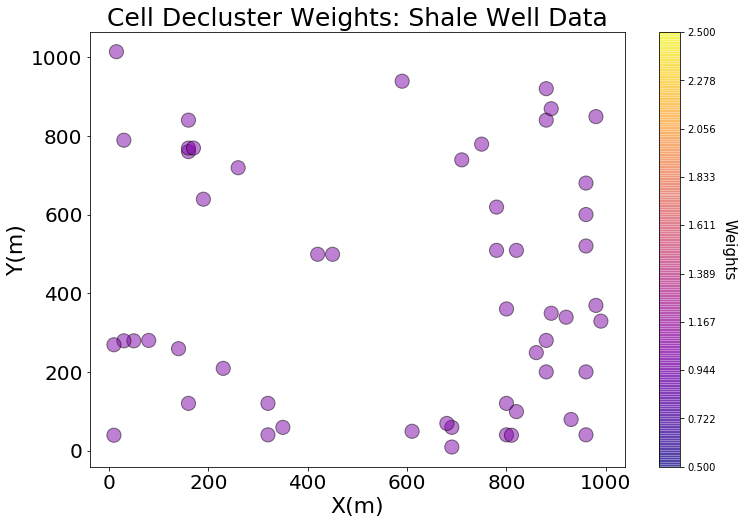

In [9]:
# plotting it my way - scaling point size by weight as well as using color
vmin = 0.5; vmax = 2.5;   # range of porosity values
plt.figure(figsize=(12,8))
im = plt.scatter(shale['X'],shale['Y'],s=200*shale['Wts'],c=shale['Wts'],marker=None,cmap=plt.cm.plasma,norm=None,vmin=vmin,vmax=vmax,alpha=0.5,verts=None,edgecolors="black")
plt.title('Cell Decluster Weights: Shale Well Data', size=25)
plt.xlabel('X(m)', size=22)
plt.xticks(fontsize=20)
plt.ylabel('Y(m)', size=22)
plt.yticks(fontsize=20)
cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
cbar.set_label('Weights',rotation=270,labelpad=20,size=15)
plt.show()

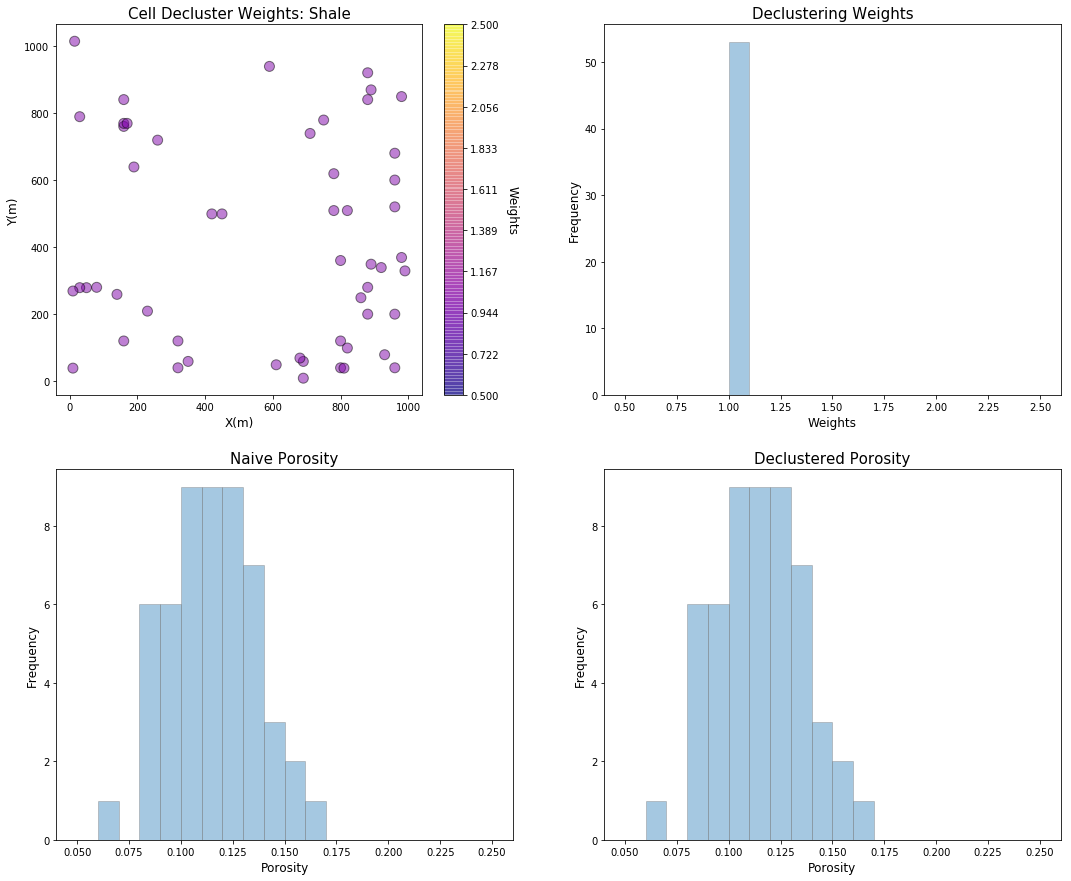

In [10]:
# Plotting histograms with map of decluster weights
plt.figure(figsize=(18,15))

plt.subplot(221)
vmin = 0.5; vmax = 2.5;   # range of porosity values
im = plt.scatter(shale['X'],shale['Y'],s=100*shale['Wts'],c=shale['Wts'],marker=None,cmap=plt.cm.plasma,norm=None,vmin=vmin,vmax=vmax,alpha=0.5,verts=None,edgecolors="black")
plt.title('Cell Decluster Weights: Shale', size=15)
plt.xlabel('X(m)', size=12)
plt.xticks(fontsize=10)
plt.ylabel('Y(m)', size=12)
plt.yticks(fontsize=10)
cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
cbar.set_label('Weights',rotation=270,labelpad=20,size=12)

plt.subplot(222)
whist = plt.hist(shale['Wts'],edgecolor='gray',bins=20,alpha=0.4,range=[vmin,vmax])
plt.title('Declustering Weights', size=15)
plt.xlabel('Weights',size=12)
plt.ylabel('Frequency',size=12)

plt.subplot(223)
naivehist = plt.hist(shale['Porosity'],edgecolor='gray',bins=20,alpha=0.4,range=[vmin/10,vmax/10])
plt.title('Naive Porosity',size=15)
plt.xlabel('Porosity',size=12)
plt.ylabel('Frequency',size=12)

plt.subplot(224)
decluhist = plt.hist(shale['Porosity'],edgecolor='gray',bins=20,alpha=0.4,range=[vmin/10,vmax/10],weights=shale['Wts'])
plt.title('Declustered Porosity',size=15)
plt.xlabel('Porosity',size=12)
plt.ylabel('Frequency',size=12)

plt.show()

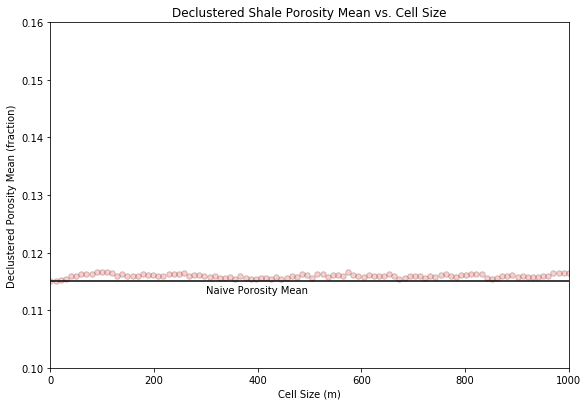

In [11]:
# mean v cell size
por_mean = np.average(shale['Porosity'].values)
plt.subplot(111)
plt.scatter(cell_sizes,dmeans, s=30, alpha = 0.2, edgecolors = "black", facecolors = 'red')
plt.xlabel('Cell Size (m)')
plt.ylabel('Declustered Porosity Mean (fraction)')
plt.title('Declustered Shale Porosity Mean vs. Cell Size')
plt.plot([0,1000],[por_mean,por_mean],color = 'black')
plt.text(300., 0.113, r'Naive Porosity Mean')
plt.ylim(0.10,0.16)
plt.xlim(0,1000)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

In [12]:
# find index of minimum declustered value and get corresponding cell size
min_dmeans = dmeans.min()
min_location = np.where(dmeans == min_dmeans)
min_cell = cell_sizes[min_location[0][0]]
print("Minimum value: " + str(min_dmeans))
print("Corresponding cell size: " + str(min_cell))

Minimum value: 0.11501478234971194
Corresponding cell size: 0.0


No noticable change due to the application of cell declustering

**1.3 Cell declustering on sandstone porosity values (outliers removed)**

In [13]:
wts, cell_sizes, dmeans = geostats.declus(sandstone,'X','Y','Porosity',iminmax = 1, noff= 10, ncell=100,cmin=10,cmax=1000)
sandstone['Wts'] = wts                            # add weights to the sample data DataFrame
sandstone.head()                                  # preview to check the sample data DataFrame

There are 164 data with:
   mean of      0.14194478804956295 
   min and max  0.09586122454769302 and 0.20438817014234475
   standard dev 0.021163198662676658 


,Unnamed: 0,Unnamed: 0.1,X,Y,Facies,Porosity,Perm,AI,Wts
0,0,0,80.0,920.0,1.0,0.164331,69.106615,5012.616594,1.351359
1,1,3,80.0,680.0,1.0,0.133723,1.558072,5710.579850,0.898230
2,2,4,80.0,600.0,1.0,0.096295,3.568959,4912.388066,1.036278
3,4,11,80.0,40.0,1.0,0.145738,0.109943,6492.944055,7.177127
4,8,19,160.0,360.0,1.0,0.148611,45.082381,6643.024955,0.727677


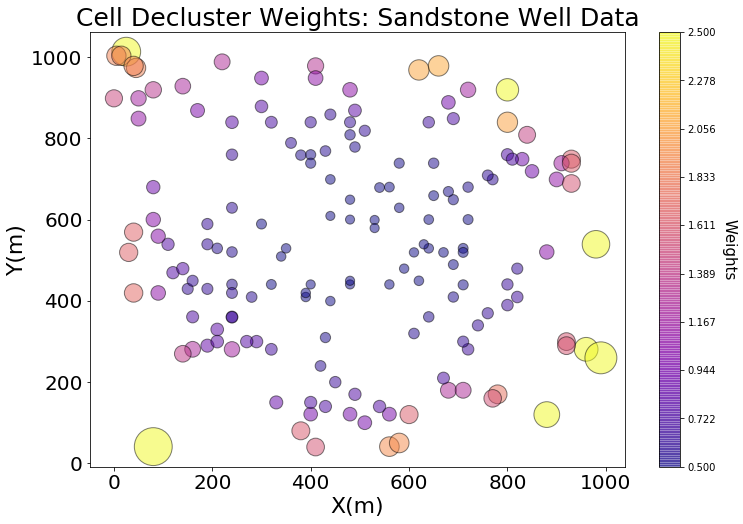

In [14]:
# plotting it my way - scaling point size by weight as well as using color
vmin = 0.5; vmax = 2.5;   # range of porosity values
plt.figure(figsize=(12,8))
im = plt.scatter(sandstone['X'],sandstone['Y'],s=200*sandstone['Wts'],c=sandstone['Wts'],marker=None,cmap=plt.cm.plasma,norm=None,vmin=vmin,vmax=vmax,alpha=0.5,verts=None,edgecolors="black")
plt.title('Cell Decluster Weights: Sandstone Well Data', size=25)
plt.xlabel('X(m)', size=22)
plt.xticks(fontsize=20)
plt.ylabel('Y(m)', size=22)
plt.yticks(fontsize=20)
cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
cbar.set_label('Weights',rotation=270,labelpad=20,size=15)
plt.show()

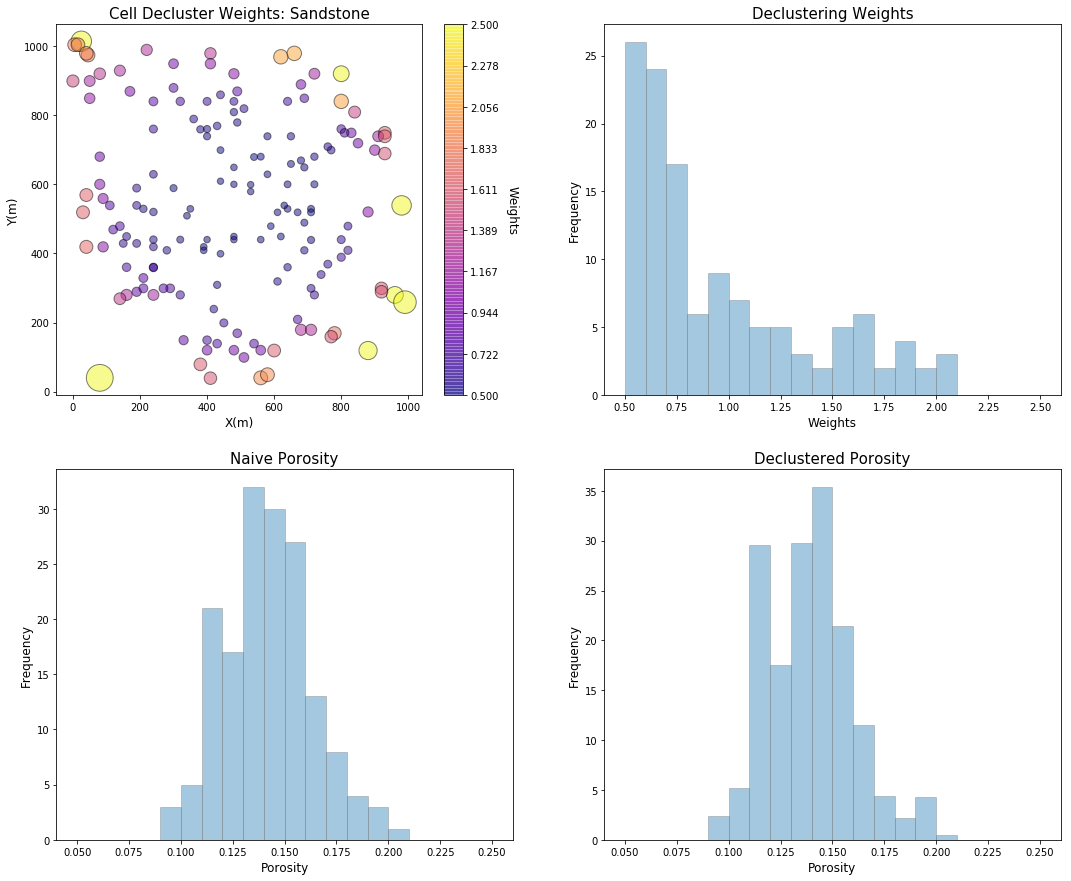

In [15]:
# Plotting histograms with map of decluster weights
plt.figure(figsize=(18,15))

plt.subplot(221)
vmin = 0.5; vmax = 2.5;   # range of porosity values
im = plt.scatter(sandstone['X'],sandstone['Y'],s=100*sandstone['Wts'],c=sandstone['Wts'],marker=None,cmap=plt.cm.plasma,norm=None,vmin=vmin,vmax=vmax,alpha=0.5,verts=None,edgecolors="black")
plt.title('Cell Decluster Weights: Sandstone', size=15)
plt.xlabel('X(m)', size=12)
plt.xticks(fontsize=10)
plt.ylabel('Y(m)', size=12)
plt.yticks(fontsize=10)
cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
cbar.set_label('Weights',rotation=270,labelpad=20,size=12)

plt.subplot(222)
whist = plt.hist(sandstone['Wts'],edgecolor='gray',bins=20,alpha=0.4,range=[vmin,vmax])
plt.title('Declustering Weights', size=15)
plt.xlabel('Weights',size=12)
plt.ylabel('Frequency',size=12)

plt.subplot(223)
naivehist = plt.hist(sandstone['Porosity'],edgecolor='gray',bins=20,alpha=0.4,range=[vmin/10,vmax/10])
plt.title('Naive Porosity',size=15)
plt.xlabel('Porosity',size=12)
plt.ylabel('Frequency',size=12)

plt.subplot(224)
decluhist = plt.hist(sandstone['Porosity'],edgecolor='gray',bins=20,alpha=0.4,range=[vmin/10,vmax/10],weights=sandstone['Wts'])
plt.title('Declustered Porosity',size=15)
plt.xlabel('Porosity',size=12)
plt.ylabel('Frequency',size=12)

plt.show()

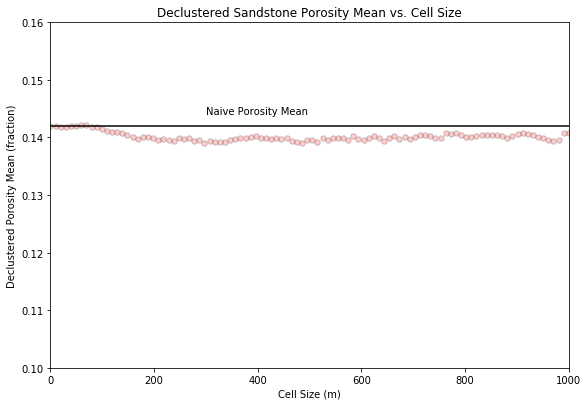

In [16]:
# mean v cell size
por_mean = np.average(sandstone['Porosity'].values)
plt.subplot(111)
plt.scatter(cell_sizes,dmeans, s=30, alpha = 0.2, edgecolors = "black", facecolors = 'red')
plt.xlabel('Cell Size (m)')
plt.ylabel('Declustered Porosity Mean (fraction)')
plt.title('Declustered Sandstone Porosity Mean vs. Cell Size')
plt.plot([0,1000],[por_mean,por_mean],color = 'black')
plt.text(300., 0.144, r'Naive Porosity Mean')
plt.ylim(0.10,0.16)
plt.xlim(0,1000)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

In [17]:
# find index of minimum declustered value and get corresponding cell size
min_dmeans = dmeans.min()
min_location = np.where(dmeans == min_dmeans)
min_cell = cell_sizes[min_location[0][0]]
print("Minimum value: " + str(min_dmeans))
print("Corresponding cell size: " + str(min_cell))

Minimum value: 0.1389551223674361
Corresponding cell size: 485.19999999999953


The entire field of interest is only 1000m x 1000m so it would not be logical to use a cell size close to 500m or half that size. Instead by looking at the plot it appears as if the declustered mean is lowered to an oscillating value by the time the cell size grows to be about 200m.

**1.4 Cell declustering on shale porosity values (raw data with outliers)**

In [18]:
# Warning that appears is notification that DataFrame is being changed not copied
wts, cell_sizes, dmeans = geostats.declus(shale_raw,'X','Y','Porosity',iminmax = 1, noff= 10, ncell=100,cmin=10,cmax=1000)
shale_raw['Wts'] = wts                            # add weights to the sample data DataFrame
shale_raw.head()                                  # preview to check the sample data DataFrame

There are 62 data with:
   mean of      0.11684148604737674 
   min and max  0.0606929054762965 and 0.16093715216411694
   standard dev 0.020261552852745553 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,Unnamed: 0,X,Y,Facies,Porosity,Perm,AI,Wts
3,8,80.0,280.0,0.0,0.102919,0.196018,6753.323723,0.931062
5,13,160.0,840.0,0.0,0.128852,0.673043,6068.296567,1.084776
6,14,160.0,760.0,0.0,0.103365,5.368073,5574.433666,0.743066
7,15,160.0,680.0,0.0,0.126885,24.314420,4201.709904,0.902986
10,22,160.0,120.0,0.0,0.142252,5.189214,7330.542384,1.369408


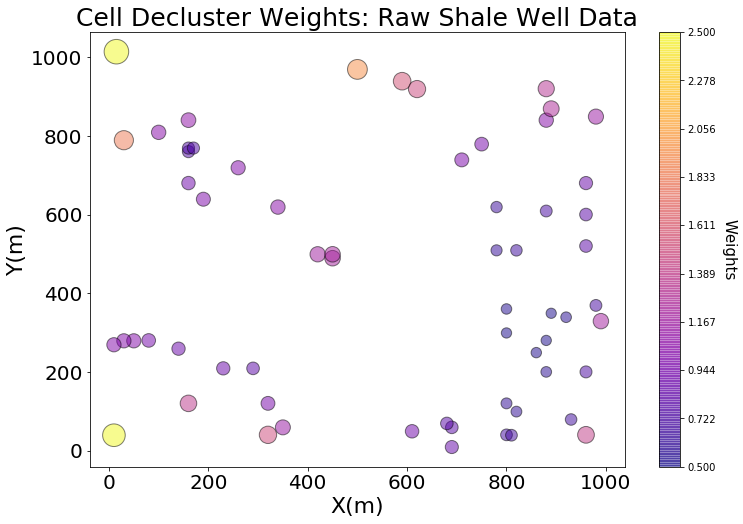

In [19]:
# plotting it my way - scaling point size by weight as well as using color
vmin = 0.5; vmax = 2.5;   # range of porosity values
plt.figure(figsize=(12,8))
im = plt.scatter(shale_raw['X'],shale_raw['Y'],s=200*shale_raw['Wts'],
                 c=shale_raw['Wts'],marker=None,cmap=plt.cm.plasma,norm=None,
                 vmin=vmin,vmax=vmax,alpha=0.5,verts=None,edgecolors="black")
plt.title('Cell Decluster Weights: Raw Shale Well Data', size=25)
plt.xlabel('X(m)', size=22)
plt.xticks(fontsize=20)
plt.ylabel('Y(m)', size=22)
plt.yticks(fontsize=20)
cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
cbar.set_label('Weights',rotation=270,labelpad=20,size=15)
plt.show()

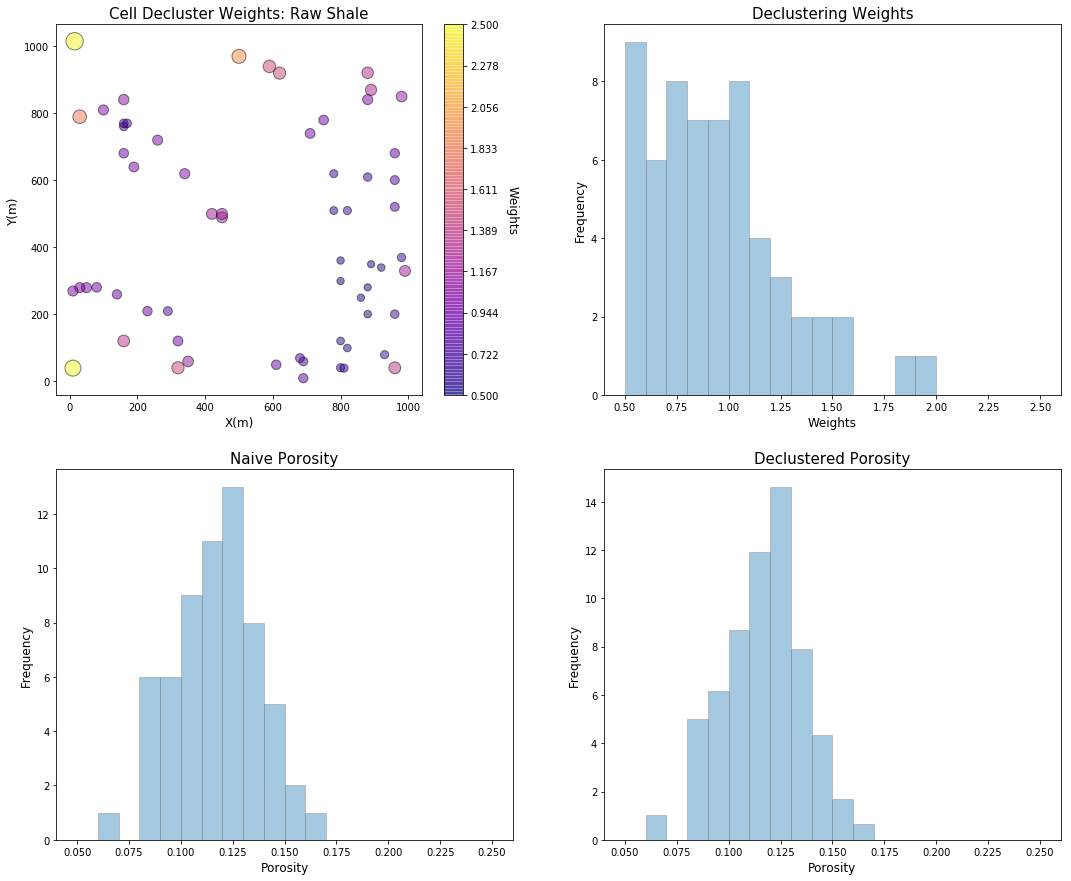

In [20]:
# Plotting histograms with map of decluster weights
plt.figure(figsize=(18,15))

plt.subplot(221)
vmin = 0.5; vmax = 2.5;   # range of porosity values
im = plt.scatter(shale_raw['X'],shale_raw['Y'],s=100*shale_raw['Wts'],
                 c=shale_raw['Wts'],marker=None,cmap=plt.cm.plasma,
                 norm=None,vmin=vmin,vmax=vmax,alpha=0.5,verts=None,edgecolors="black")
plt.title('Cell Decluster Weights: Raw Shale', size=15)
plt.xlabel('X(m)', size=12)
plt.xticks(fontsize=10)
plt.ylabel('Y(m)', size=12)
plt.yticks(fontsize=10)
cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
cbar.set_label('Weights',rotation=270,labelpad=20,size=12)

plt.subplot(222)
whist = plt.hist(shale_raw['Wts'],edgecolor='gray',bins=20,alpha=0.4,range=[vmin,vmax])
plt.title('Declustering Weights', size=15)
plt.xlabel('Weights',size=12)
plt.ylabel('Frequency',size=12)

plt.subplot(223)
naivehist = plt.hist(shale_raw['Porosity'],edgecolor='gray',bins=20,alpha=0.4,range=[vmin/10,vmax/10])
plt.title('Naive Porosity',size=15)
plt.xlabel('Porosity',size=12)
plt.ylabel('Frequency',size=12)

plt.subplot(224)
decluhist = plt.hist(shale_raw['Porosity'],edgecolor='gray',bins=20,alpha=0.4,
                     range=[vmin/10,vmax/10],weights=shale_raw['Wts'])
plt.title('Declustered Porosity',size=15)
plt.xlabel('Porosity',size=12)
plt.ylabel('Frequency',size=12)

plt.show()

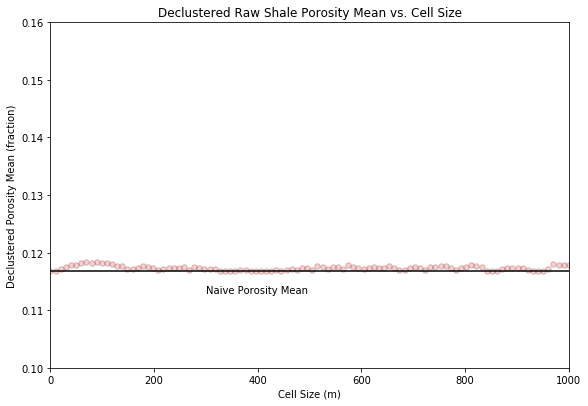

In [21]:
# mean v cell size
por_mean = np.average(shale_raw['Porosity'].values)
plt.subplot(111)
plt.scatter(cell_sizes,dmeans, s=30, alpha = 0.2, edgecolors = "black", facecolors = 'red')
plt.xlabel('Cell Size (m)')
plt.ylabel('Declustered Porosity Mean (fraction)')
plt.title('Declustered Raw Shale Porosity Mean vs. Cell Size')
plt.plot([0,1000],[por_mean,por_mean],color = 'black')
plt.text(300., 0.113, r'Naive Porosity Mean')
plt.ylim(0.10,0.16)
plt.xlim(0,1000)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

In [22]:
# find index of minimum declustered value and get corresponding cell size
min_dmeans = dmeans.min()
min_location = np.where(dmeans == min_dmeans)
min_cell = cell_sizes[min_location[0][0]]
print("Minimum value: " + str(min_dmeans))
print("Corresponding cell size: " + str(min_cell))

Minimum value: 0.11673087358883076
Corresponding cell size: 425.79999999999967


Visual inspection of the field would suggest that a cell size of ~1000m will not be particularly illuminating. Looking at the plot of the declustered mean against the cell size, it does not appear to favor any particular size.

**1.5 Cell declustering on sandstone porosity values (raw data)**

In [23]:
# Warning that appears is notification that DataFrame is being changed not copied
wts, cell_sizes, dmeans = geostats.declus(sandstone_raw,'X','Y','Porosity',
                                          iminmax = 1, noff= 10, ncell=100,cmin=10,cmax=1000)
sandstone_raw['Wts'] = wts                            # add weights to the sample data DataFrame
sandstone_raw.head()                                  # preview to check the sample data DataFrame

There are 209 data with:
   mean of      0.14908314399446512 
   min and max  0.09586122454769302 and 0.2216072275194954
   standard dev 0.026038833669755866 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,Unnamed: 0,X,Y,Facies,Porosity,Perm,AI,Wts
0,0,80.0,920.0,1.0,0.164331,69.106615,5012.616594,0.724622
1,3,80.0,680.0,1.0,0.133723,1.558072,5710.579850,2.674839
2,4,80.0,600.0,1.0,0.096295,3.568959,4912.388066,1.261148
4,11,80.0,40.0,1.0,0.145738,0.109943,6492.944055,8.711087
8,19,160.0,360.0,1.0,0.148611,45.082381,6643.024955,0.733433


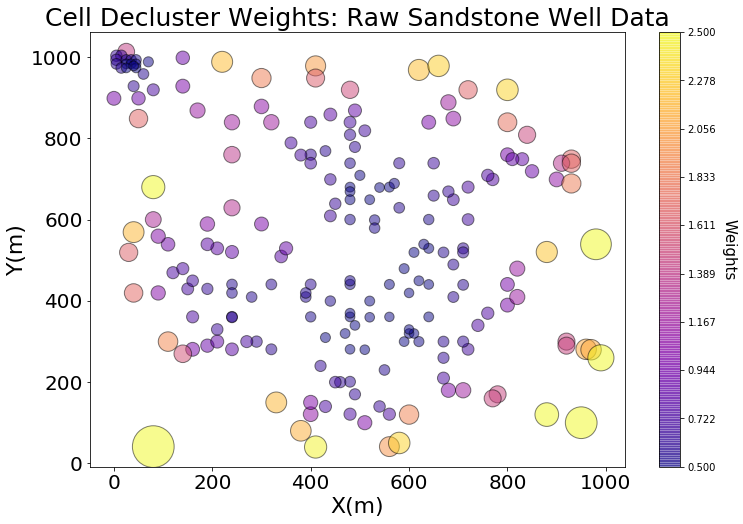

In [24]:
# plotting it my way - scaling point size by weight as well as using color
vmin = 0.5; vmax = 2.5;   # range of porosity values
plt.figure(figsize=(12,8))
im = plt.scatter(sandstone_raw['X'],sandstone_raw['Y'],s=200*sandstone_raw['Wts'],
                 c=sandstone_raw['Wts'],marker=None,cmap=plt.cm.plasma,norm=None,
                 vmin=vmin,vmax=vmax,alpha=0.5,verts=None,edgecolors="black")
plt.title('Cell Decluster Weights: Raw Sandstone Well Data', size=25)
plt.xlabel('X(m)', size=22)
plt.xticks(fontsize=20)
plt.ylabel('Y(m)', size=22)
plt.yticks(fontsize=20)
cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
cbar.set_label('Weights',rotation=270,labelpad=20,size=15)
plt.show()

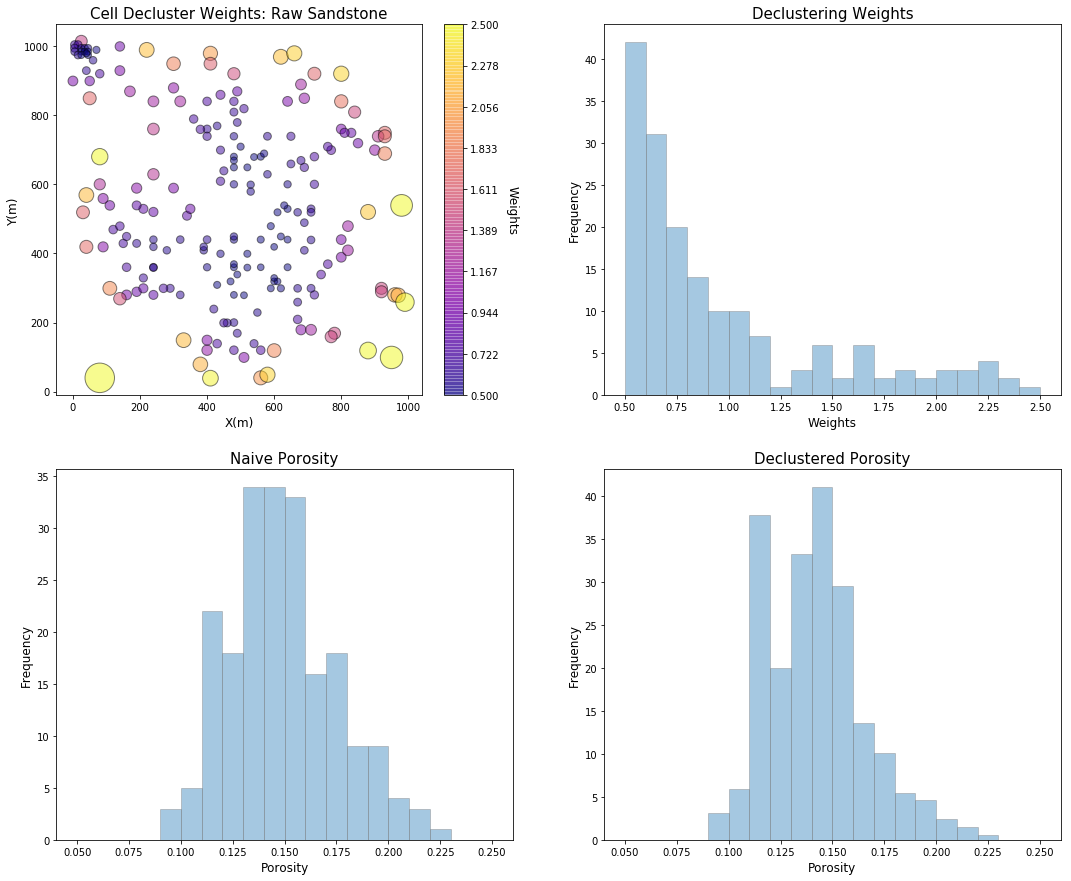

In [25]:
# Plotting histograms with map of decluster weights
plt.figure(figsize=(18,15))

plt.subplot(221)
vmin = 0.5; vmax = 2.5;   # range of porosity values
im = plt.scatter(sandstone_raw['X'],sandstone_raw['Y'],s=100*sandstone_raw['Wts'],
                 c=sandstone_raw['Wts'],marker=None,cmap=plt.cm.plasma,norm=None,
                 vmin=vmin,vmax=vmax,alpha=0.5,verts=None,edgecolors="black")
plt.title('Cell Decluster Weights: Raw Sandstone', size=15)
plt.xlabel('X(m)', size=12)
plt.xticks(fontsize=10)
plt.ylabel('Y(m)', size=12)
plt.yticks(fontsize=10)
cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
cbar.set_label('Weights',rotation=270,labelpad=20,size=12)

plt.subplot(222)
whist = plt.hist(sandstone_raw['Wts'],edgecolor='gray',bins=20,alpha=0.4,range=[vmin,vmax])
plt.title('Declustering Weights', size=15)
plt.xlabel('Weights',size=12)
plt.ylabel('Frequency',size=12)

plt.subplot(223)
naivehist = plt.hist(sandstone_raw['Porosity'],edgecolor='gray',bins=20,alpha=0.4,range=[vmin/10,vmax/10])
plt.title('Naive Porosity',size=15)
plt.xlabel('Porosity',size=12)
plt.ylabel('Frequency',size=12)

plt.subplot(224)
decluhist = plt.hist(sandstone_raw['Porosity'],edgecolor='gray',bins=20,alpha=0.4,
                     range=[vmin/10,vmax/10],weights=sandstone_raw['Wts'])
plt.title('Declustered Porosity',size=15)
plt.xlabel('Porosity',size=12)
plt.ylabel('Frequency',size=12)

plt.show()

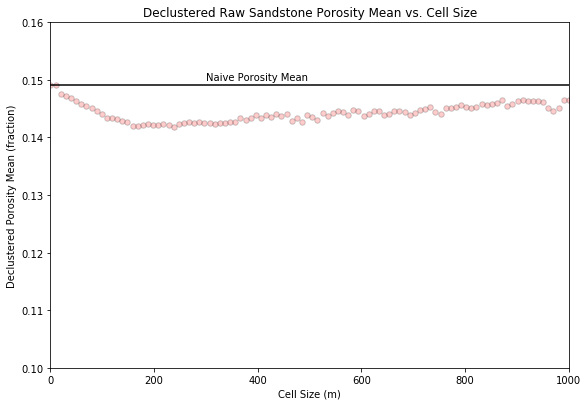

In [26]:
# mean v cell size
por_mean = np.average(sandstone_raw['Porosity'].values)
plt.subplot(111)
plt.scatter(cell_sizes,dmeans, s=30, alpha = 0.2, edgecolors = "black", facecolors = 'red')
plt.xlabel('Cell Size (m)')
plt.ylabel('Declustered Porosity Mean (fraction)')
plt.title('Declustered Raw Sandstone Porosity Mean vs. Cell Size')
plt.plot([0,1000],[por_mean,por_mean],color = 'black')
plt.text(300., 0.150, r'Naive Porosity Mean')
plt.ylim(0.10,0.16)
plt.xlim(0,1000)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

In [27]:
# find index of minimum declustered value and get corresponding cell size
min_dmeans = dmeans.min()
min_location = np.where(dmeans == min_dmeans)
min_cell = cell_sizes[min_location[0][0]]
print("Minimum value: " + str(min_dmeans))
print("Corresponding cell size: " + str(min_cell))

Minimum value: 0.14187618800436513
Corresponding cell size: 237.70000000000007


With some rounding, we may be comfortable using a cell size of 200m based on this declustering analysis. Visual analysis of the field would suggest that this cell size provides reasonable coverage of the data, despite some cells that might be sparse near some of the boundaries.

**Saving data with declustered weights**

In [28]:
# save and output the DataFrames as csv
sandstone.to_csv('DeclusteredSandstone.csv')
shale.to_csv('DeclusteredShale.csv')
sandstone_raw.to_csv('DeclusteredRawSandstone.csv')
shale_raw.to_csv('DeclusteredRawShale.csv')

### 2. Tested signiﬁcance of diﬀerence in mean porosity and permeability between the facies (Hypothesis Testing

In [29]:
# loading declustered data - both raw and outliers removed
clean_sandstone = pd.read_csv('Data/DeclusteredSandstone.csv')
clean_shale = pd.read_csv('Data/DeclusteredShale.csv')
raw_sandstone = pd.read_csv('Data/DeclusteredRawSandstone.csv')
raw_shale = pd.read_csv('Data/DeclusteredRawShale.csv')
# removing the extra data column
del clean_sandstone['Unnamed: 0']
del clean_shale['Unnamed: 0']
del raw_sandstone['Unnamed: 0']
del raw_shale['Unnamed: 0']
# concatenate dataframes to recreate totalsets
raw_df = pd.concat([raw_sandstone, raw_shale])
clean_df = pd.concat([clean_sandstone, clean_shale])

**2.1 Plotting empirical pdfs and cdfs**
Visually inspect the declustered distributions of porosity and permeability. First define the data set to be used, either the raw data or the data after the removal of outliers.

In [30]:
# set relevant dataframes to names sandstone and shale
    # can choose raw or clean data by specifying this assignment
sandstone = raw_sandstone
shale = raw_shale

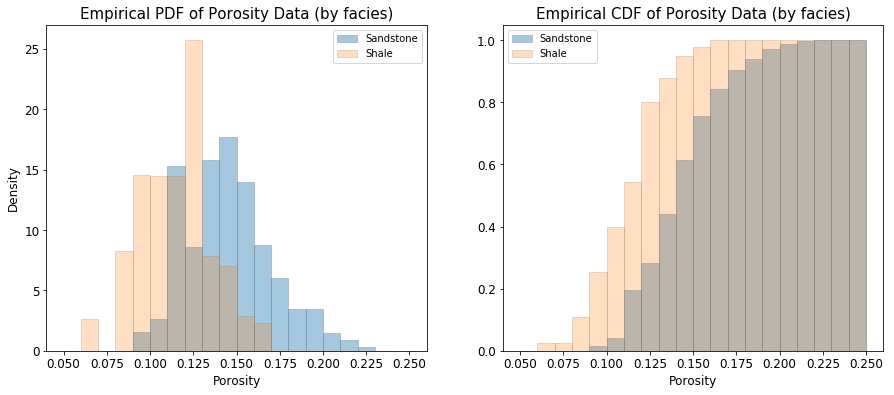

In [31]:
# plotting the empirical pdf and cdf of the porosity data
plt.figure(figsize=(15,6))

# pdf of porosity data by facies 
plt.subplot(121)
vmin = 0.05; vmax = 0.25; # range of porosity values
im_sand = plt.hist(sandstone['Porosity'], edgecolor='gray', density=True,weights=sandstone['Wts'],
                   bins=20, alpha=0.4, range=[vmin,vmax],label='Sandstone')
im_shale = plt.hist(shale['Porosity'], edgecolor='gray', density=True,weights=shale['Wts'],
                    bins=20, alpha=0.25, range=[vmin,vmax],label='Shale')
plt.title('Empirical PDF of Porosity Data (by facies)',size=15)
plt.ylabel('Density',size=12)
plt.xlabel('Porosity',size=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper right')

# cdf of porosity data by facies
plt.subplot(122)
im_sand = plt.hist(sandstone['Porosity'], edgecolor='gray', density=True,weights=sandstone['Wts'],
                   cumulative=True, bins=20, alpha=0.4, range=[vmin,vmax],label='Sandstone')
im_shale = plt.hist(shale['Porosity'], edgecolor='gray', density=True,weights=shale['Wts'],
                    cumulative=True, bins=20, alpha=0.25, range=[vmin,vmax],label='Shale')
plt.title('Empirical CDF of Porosity Data (by facies)',size=15)
plt.xlabel('Porosity',size=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper left')

plt.show()

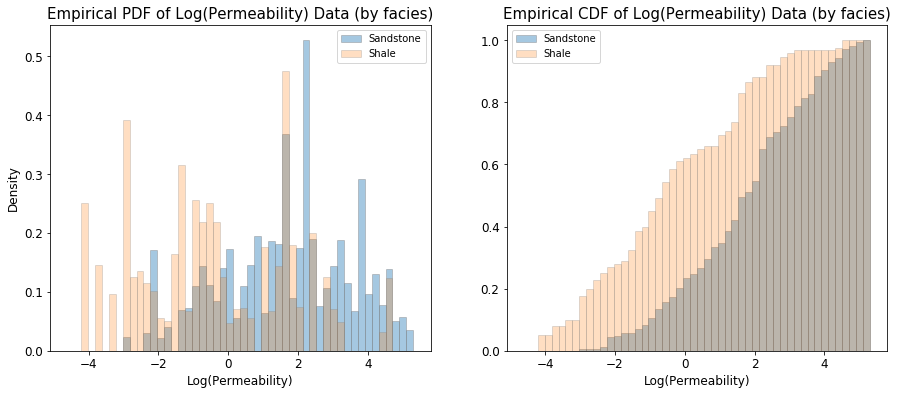

In [32]:
# plotting the empirical pdf and cdf of the permeability data
plt.figure(figsize=(15,6))

# pdf of porosity data by facies 
plt.subplot(121)
vmin = 0.01; vmax = 200; # range of permeability values
im_sand = plt.hist(np.log(sandstone['Perm']), edgecolor='gray', density=True,weights=sandstone['Wts'],
                   bins=50, alpha=0.4, range=[np.log(vmin),np.log(vmax)],label='Sandstone')
im_shale = plt.hist(np.log(shale['Perm']), edgecolor='gray', density=True,weights=shale['Wts'],
                    bins=50, alpha=0.25, range=[np.log(vmin),np.log(vmax)],label='Shale')
plt.title('Empirical PDF of Log(Permeability) Data (by facies)',size=15)
plt.ylabel('Density',size=12)
plt.xlabel('Log(Permeability)',size=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper right')

# cdf of porosity data by facies
plt.subplot(122)
im_sand = plt.hist(np.log(sandstone['Perm']), edgecolor='gray', density=True,weights=sandstone['Wts'],
                   cumulative=True, bins=50, alpha=0.4, range=[np.log(vmin),np.log(vmax)],label='Sandstone')
im_shale = plt.hist(np.log(shale['Perm']), edgecolor='gray', density=True,weights=shale['Wts'],
                    cumulative=True, bins=50, alpha=0.25, range=[np.log(vmin),np.log(vmax)],label='Shale')
plt.title('Empirical CDF of Log(Permeability) Data (by facies)',size=15)
plt.xlabel('Log(Permeability)',size=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper left')

plt.show()

**2.2 Computing Declustered Statistics for Porosity**

In [33]:
def weighted_avg_and_std(values, weights): # function to calculate weighted mean and st. dev., from Eric O Lebigot, stack overflow,
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

sandstone_avg, sandstone_stdev = weighted_avg_and_std(sandstone['Porosity'],sandstone['Wts'])
print('Sandstone: Declustered mean = ' + str(round(sandstone_avg,3)) + ' and declustered standard deviation = ' + str(round(sandstone_stdev,3)))
print('')
shale_avg, shale_stdev = weighted_avg_and_std(shale['Porosity'],shale['Wts'])
print('Shale: Declustered mean = ' + str(round(shale_avg,3)) + ' and declustered standard deviation = ' + str(round(shale_stdev,3)))

Sandstone: Declustered mean = 0.145 and declustered standard deviation = 0.025

Shale: Declustered mean = 0.115 and declustered standard deviation = 0.021


**2.3 T-Test and Welch's T-Test for Porosity**

In [34]:

alpha = 0.05
# t-test
t_sandstone, p_sandstone = st.ttest_ind_from_stats(sandstone_avg,sandstone_stdev,len(sandstone),
                                                  shale_avg,shale_stdev,len(shale),equal_var=True)
if p_sandstone < alpha:
    decision = 'reject the null hypothesis, mean values are statistically different'
else:
    decision = 'accept the null hypothesis, mean values are statistically similar'

print('Porosity T-Test Results:')
print('p-value from the t-test was ' + str(round(p_sandstone,5)))
print('Therefore, we ' + decision)
print('')

# Welch's t-test
t_sandstone, p_sandstone = st.ttest_ind_from_stats(sandstone_avg,sandstone_stdev,len(sandstone),
                                                  shale_avg,shale_stdev,len(shale),equal_var=False)
if p_sandstone < alpha:
    decision = 'reject the null hypothesis, mean values are statistically different'
else:
    decision = 'accept the null hypothesis, mean values are statistically similar'

print('Porosity Welch\'s T-Test Results:')
print('p-value from the Welch\'s t-test was ' + str(round(p_sandstone,5)))
print('Therefore, we ' + decision)
print('')

Porosity T-Test Results:
p-value from the t-test was 0.0
Therefore, we reject the null hypothesis, mean values are statistically different

Porosity Welch's T-Test Results:
p-value from the Welch's t-test was 0.0
Therefore, we reject the null hypothesis, mean values are statistically different



**2.4 Computing Declustered Statistics for Permeability**


In [35]:
sandstone_avg, sandstone_stdev = weighted_avg_and_std(sandstone['Perm'],sandstone['Wts'])
print('Sandstone: Declustered mean = ' + str(round(sandstone_avg,3)) + ' and declustered standard deviation = ' + str(round(sandstone_stdev,3)))
print('')
shale_avg, shale_stdev = weighted_avg_and_std(shale['Perm'],shale['Wts'])
print('Shale: Declustered mean = ' + str(round(shale_avg,3)) + ' and declustered standard deviation = ' + str(round(shale_stdev,3)))

Sandstone: Declustered mean = 480.609 and declustered standard deviation = 2509.476

Shale: Declustered mean = 7.031 and declustered standard deviation = 23.642


**2.5 T-Test and Welch's T-Test for Permeability**


In [36]:
alpha = 0.05
# t-test
t_sandstone, p_sandstone = st.ttest_ind_from_stats(sandstone_avg,sandstone_stdev,len(sandstone),
                                                  shale_avg,shale_stdev,len(shale),equal_var=True)
if p_sandstone < alpha:
    decision = 'reject the null hypothesis, mean values are statistically different'
else:
    decision = 'accept the null hypothesis, mean values are statistically similar'

print('Porosity T-Test Results:')
print('p-value from the t-test was ' + str(round(p_sandstone,5)))
print('Therefore, we ' + decision)
print('')

# Welch's t-test
t_sandstone, p_sandstone = st.ttest_ind_from_stats(sandstone_avg,sandstone_stdev,len(sandstone),
                                                  shale_avg,shale_stdev,len(shale),equal_var=False)
if p_sandstone < alpha:
    decision = 'reject the null hypothesis, mean values are statistically different'
else:
    decision = 'accept the null hypothesis, mean values are statistically similar'

print('Porosity Welch\'s T-Test Results:')
print('p-value from the Welch\'s t-test was ' + str(round(p_sandstone,5)))
print('Therefore, we ' + decision)
print('')

Porosity T-Test Results:
p-value from the t-test was 0.13898
Therefore, we accept the null hypothesis, mean values are statistically similar

Porosity Welch's T-Test Results:
p-value from the Welch's t-test was 0.00692
Therefore, we reject the null hypothesis, mean values are statistically different



In [37]:
print(sandstone_stdev)
print(shale_stdev)

2509.476134017255
23.641511757602736


In [38]:
p_value = 1 - st.f.cdf(sandstone_stdev**2/shale_stdev**2, dfn=len(sandstone)-1, dfd=len(shale)-1)
print('The p-value for the F-test for difference is variances is ' + str(round(p_value,3)))

The p-value for the F-test for difference is variances is 0.0


The p-value from the F-test is less than our alpha of 0.05, and so we would conclude that the variances between the facies are statistically different and therefore unequal. This would suggest that the Welch's T-test is more appropriate for assessing the difference in mean values as it does not assume equal variance (which we have now proven to be a poor assumption). So therefore we will accept the result from the Welch test and say that the mean values are statistically different.

**2.6 Conclusions**

P-values for both the standard t-test and Welch's t-test on the declustered statistics for the distributions split by facies indicate that the distribution of porosity, by facies, is statistically different (to a 95\% confidence level). The permeability data was further tested using the F-test to check for equality of variances. This test revealed that the variances for the sandstone and shale data are statistically different, making the Welch test more appropriate to check the equality of the mean values. The Welch test indicated that the mean values for permeability by facies are statistically different.

### 3.Reevaluated univariate statistics based on declustered data

### 4. Assessed heterogeneity in the reservoir (Coeﬃcient of variation, Dykstra-Parsons, and Lorenz)**

Below we assess reservoir heterogeneity based on static measures. Namely, we compute

i.) Coefficient of variation 

ii.) Dykstra-Parson's Coefficient

iii.) Lorenz Coefficient

In [39]:
Sandstone_cleaned = pd.read_csv('Data/DeclusteredSandstone.csv')
Shale_cleaned = pd.read_csv('Data/DeclusteredShale.csv')
Sandstone_raw = pd.read_csv('Data/DeclusteredRawSandstone.csv')
Shale_raw = pd.read_csv('Data/DeclusteredRawShale.csv')
Facies_raw = pd.concat([Sandstone_raw,Shale_raw]) # Includes all facies in the reservoir before outliers removed
Facies_cleaned = pd.concat([Sandstone_cleaned,Shale_cleaned]) # Includes all facies in the reservoir after outliers removed
#Facies_raw.to_csv('AllDataRaw.csv')
#Facies_cleaned.to_csv('AllDataCleaned.csv')

In [40]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return average, math.sqrt(variance)

**4.1 Coefficient of Variation w.r.t. Permeability**

In [41]:
def comp_COV(dataframe,measure,weights):
    # Returns the Coefficient of Variation based on population mean and standard deviation
    weighted_mean, weighted_std = weighted_avg_and_std(dataframe[measure].values, weights)
    return weighted_std/weighted_mean

In [42]:
COV_Sandstone = comp_COV(Sandstone_cleaned,'Perm',weights=Sandstone_cleaned['Wts'].values)
COV_Shale = comp_COV(Shale_cleaned,'Perm',weights=Shale_cleaned['Wts'].values)
COV_SandstoneRaw = comp_COV(Sandstone_raw,'Perm',weights=Sandstone_raw['Wts'].values)
COV_ShaleRaw = comp_COV(Shale_raw,'Perm',weights=Shale_raw['Wts'].values)
COV_FaciesRaw = comp_COV(Facies_raw,'Perm',weights=Facies_raw['Wts'].values)
COV_FaciesCleaned = comp_COV(Facies_cleaned,'Perm',weights=Facies_cleaned['Wts'].values)

In [43]:
print('Cleaned Data')
print('Coefficient of Variation (Reservoir): ' + str(COV_FaciesCleaned))
print('Coefficient of Variation (Sandstone): ' + str(COV_Sandstone))
print('Coefficient of Variation (Shale): ' + str(COV_Shale))
print('')
print('Raw Data')
print('Coefficient of Variation (Reservoir-Raw): ' + str(COV_FaciesRaw))
print('Coefficient of Variation (Sandstone-Raw): ' + str(COV_SandstoneRaw))
print('Coefficient of Variation (Shale-Raw): ' + str(COV_ShaleRaw))

Cleaned Data
Coefficient of Variation (Reservoir): 2.0013441448324802
Coefficient of Variation (Sandstone): 1.6162400806067643
Coefficient of Variation (Shale): 1.4229212625543828

Raw Data
Coefficient of Variation (Reservoir-Raw): 6.436236856491556
Coefficient of Variation (Sandstone-Raw): 5.221453813250974
Coefficient of Variation (Shale-Raw): 3.3626832497000945


**4.2 Dykstra-Parson's Coefficient**

In [44]:
def comp_DykstraParsons(dataframe,measure):
    P50 = np.percentile(dataframe[measure].values,50)
    P16 = np.percentile(dataframe[measure].values,16)
    return (P50-P16)/P50

In [45]:
print('Cleaned Data')
print('Dykstra-Parsons Coefficient (Reservoir): ' + str(comp_DykstraParsons(Facies_cleaned,'Perm')))
print('Dykstra-Parsons Coefficient (Sandstone): ' + str(comp_DykstraParsons(Sandstone_cleaned,'Perm')))
print('Dykstra-Parsons Coefficient (Shale): ' + str(comp_DykstraParsons(Shale_cleaned,'Perm')))
print('')
print('Raw Data')
print('Dykstra-Parsons Coefficient (Reservoir-Raw): ' + str(comp_DykstraParsons(Facies_raw,'Perm')))
print('Dykstra-Parsons Coefficient (Sandstone-Raw): ' + str(comp_DykstraParsons(Sandstone_raw,'Perm')))
print('Dykstra-Parsons Coefficient (Shale-Raw): ' + str(comp_DykstraParsons(Shale_raw,'Perm')))

Cleaned Data
Dykstra-Parsons Coefficient (Reservoir): 0.8826738515335498
Dykstra-Parsons Coefficient (Sandstone): 0.8752169349388415
Dykstra-Parsons Coefficient (Shale): 0.8053962101089088

Raw Data
Dykstra-Parsons Coefficient (Reservoir-Raw): 0.9123308170262382
Dykstra-Parsons Coefficient (Sandstone-Raw): 0.8714318837087329
Dykstra-Parsons Coefficient (Shale-Raw): 0.8670086754604851


**4.3 Univariate Analysis - Effect of Declustering**

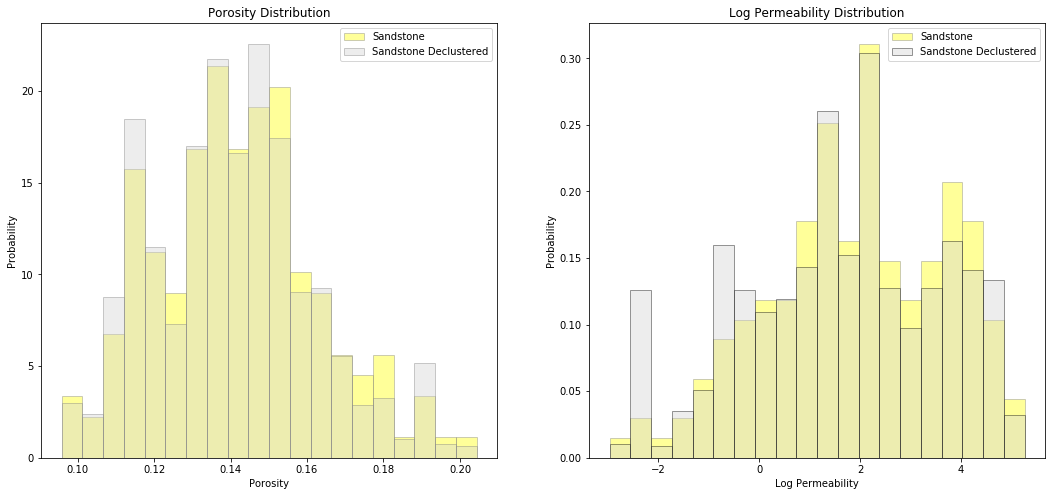

In [46]:
# univariate histograms
n_bins_sandstone = 20
n_bins_shale = 10

fig, ax2 = plt.subplots(1,2, figsize=(18,8))

# Porosity
ax2[0].hist(Sandstone_cleaned['Porosity'].values,  density=True, bins=n_bins_sandstone, edgecolor='gray', alpha=0.4, color='yellow', label='Sandstone')
ax2[0].hist(Sandstone_cleaned['Porosity'].values,  density=True, bins=n_bins_sandstone, weights=Sandstone_cleaned['Wts'], edgecolor='gray', alpha=0.4, color='lightgray', label='Sandstone Declustered')
ax2[0].set_title('Porosity Distribution')
ax2[0].set_ylabel('Probability')
ax2[0].set_xlabel('Porosity')
ax2[0].legend()

# Permeability
ax2[1].hist(np.log(Sandstone_cleaned['Perm'].values), density=True, bins=n_bins_sandstone, edgecolor='gray', alpha=0.4, color='yellow', label='Sandstone')
ax2[1].hist(np.log(Sandstone_cleaned['Perm'].values), density=True, bins=n_bins_sandstone,weights=Sandstone_cleaned['Wts'], edgecolor='black', alpha=0.4, color='lightgray', label='Sandstone Declustered')
ax2[1].set_title('Log Permeability Distribution')
ax2[1].set_ylabel('Probability')
ax2[1].set_xlabel('Log Permeability')
ax2[1].legend()

plt.show()

NameError: name 'sp' is not defined

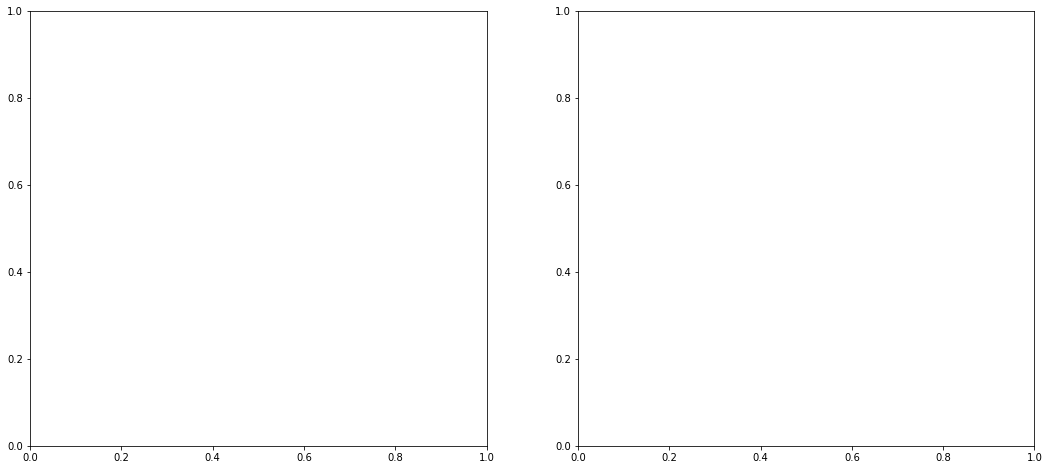

In [47]:
fig, ax2 = plt.subplots(1,2, figsize=(18,8))

# Porosity
mu_por,sigma_por = weighted_avg_and_std(Sandstone_cleaned['Porosity'].values, Sandstone_cleaned['Wts'].values)
x = np.linspace(sp.norm.ppf(0.01),sp.norm.ppf(0.99), 2500)
ax2[0].hist(Sandstone_cleaned['Porosity'].values,  density=True, bins=n_bins_sandstone, weights=Sandstone_cleaned['Wts'], edgecolor='gray', alpha=0.4, color='yellow', label='Sandstone Declustered')
ax2[0].plot(x,sp.norm.pdf(x, mu_por, sigma_por),color='k',label='Approximation of PDF')
ax2[0].set_xlim(0.05,0.25)
ax2[0].set_title('Porosity Distribution')
ax2[0].set_ylabel('Probability')
ax2[0].set_xlabel('Porosity')
ax2[0].legend()

# Permeability
mu_perm, sigma_perm = weighted_avg_and_std(Sandstone_cleaned['Perm'].values, Sandstone_cleaned['Wts'].values)
ax2[1].hist(np.log(Sandstone_cleaned['Perm'].values), density=True, bins=n_bins_sandstone,weights=Sandstone_cleaned['Wts'], edgecolor='black', alpha=0.4, color='yellow', label='Sandstone Declustered')
ax2[1].plot(x,sp.norm.pdf(x, 1.5, .75),color='k',label='Approximation of PDF')
ax2[1].set_title('Permeability Distribution')
ax2[1].set_ylabel('Probability')
ax2[1].set_xlabel('Permeability')
ax2[1].legend()

plt.show()

### 5. Developed initial uncertainty model of porosity and permeability (Bootstrap)

In [48]:
# loading declustered data - both raw and outliers removed
clean_sandstone = pd.read_csv('DeclusteredSandstone.csv')
clean_shale = pd.read_csv('DeclusteredShale.csv')
raw_sandstone = pd.read_csv('DeclusteredRawSandstone.csv')
raw_shale = pd.read_csv('DeclusteredRawShale.csv')
# removing the extra data column
del clean_sandstone['Unnamed: 0']
del clean_shale['Unnamed: 0']
del raw_sandstone['Unnamed: 0']
del raw_shale['Unnamed: 0']
# concatenate dataframes to recreate totalsets
raw_df = pd.concat([raw_sandstone, raw_shale])
clean_df = pd.concat([clean_sandstone, clean_shale])

**5.1 Uncertainty Model for Porosity**

Use the declustered weights to bootstrap the porosity distribution and develop an uncertainty model to assess the uncertainty in the porosity mean and standard deviation.

In [49]:
# adjust GSLIB histogram plotting functionality
def hist_st(array,xmin,xmax,log,cumul,bins,weights,xlabel,title,col):  
    cs = plt.hist(array, alpha = 0.2, color = col, edgecolor = 'black', bins=bins, range = [xmin,xmax], weights = weights, log = log, cumulative = cumul)
    plt.title(title)
    plt.xlabel(xlabel); plt.ylabel('Frequency') 
    return

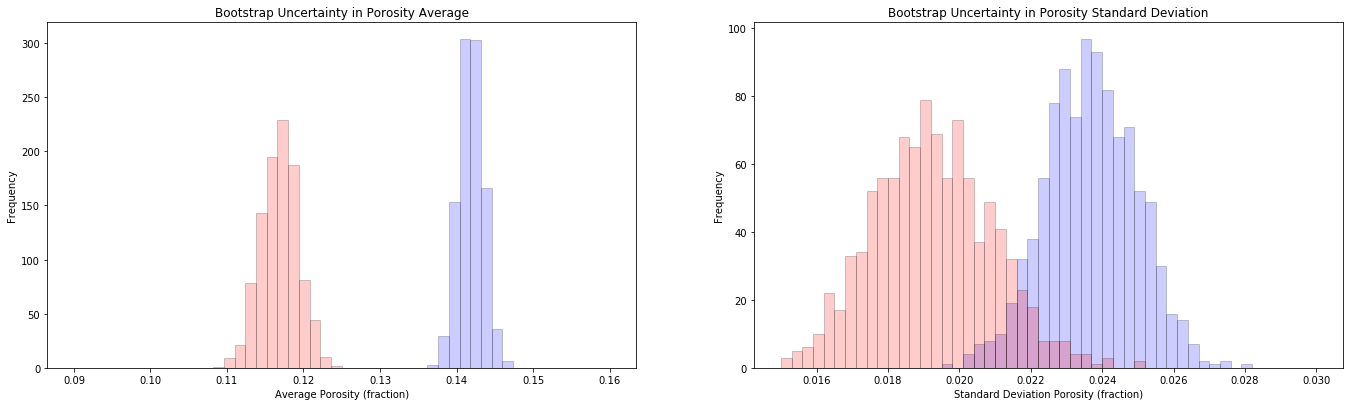

Summary Statistics for Bootstrap Sandstone Porosity Mean Realizations:
DescribeResult(nobs=1000, minmax=(0.13708661622458201, 0.14706540171232715), mean=0.14185454032390044, variance=2.54860031822272e-06, skewness=0.06773955437871011, kurtosis=-0.11726891510823245)
P10 0.14, P50 0.142, P90 0.144

Summary Statistics for Bootstrap Shale Porosity Mean Realizations:
DescribeResult(nobs=1000, minmax=(0.10857379885551995, 0.12438944731943602), mean=0.11683317206180203, variance=5.904407808334238e-06, skewness=-0.02928093500622421, kurtosis=-0.13193188234356157)
P10 0.114, P50 0.117, P90 0.12

Summary Statistics for Bootstrap Sandstone Porosity Standard Deviation Realizations:
DescribeResult(nobs=1000, minmax=(0.019609902737118594, 0.028073260852324255), mean=0.023678253143397398, variance=1.6307872181975062e-06, skewness=-0.013868084159449935, kurtosis=-0.0946583641922345)
P10 0.022, P50 0.024, P90 0.025

Summary Statistics for Bootstrap Shale Porosity Standard Deviation Realizations:
Descri

In [50]:
# do it by facies
L = 1000                                   # set the number of realizations
mean_sand = np.zeros(L); stdev_sand = np.zeros(L)    # declare arrays to hold the realizations of the statistics
mean_shale = np.zeros(L); stdev_shale = np.zeros(L)    # declare arrays to hold the realizations of the statistics
for l in range(0, L):                      # loop over realizations
    samples_sand = random.choices(raw_sandstone['Porosity'].values, weights=raw_sandstone['Wts'].values,
                                  cum_weights=None, k=len(raw_sandstone))
    samples_shale = random.choices(raw_shale['Porosity'].values, weights=raw_shale['Wts'].values,
                                  cum_weights=None, k=len(raw_shale))
    mean_sand[l] = np.average(samples_sand)
    mean_shale[l] = np.average(samples_shale)
    stdev_sand[l] = np.std(samples_sand)
    stdev_shale[l] = np.std(samples_shale)
    
plt.subplot(121)
hist_st(mean_sand,0.09,0.16,False,False,50,None,
       'Average Porosity (fraction)','Bootstrap Uncertainty in Porosity Average','blue')
hist_st(mean_shale,0.09,0.16,False,False,50,None,
       'Average Porosity (fraction)','Bootstrap Uncertainty in Porosity Average','red')

plt.subplot(122)
hist_st(stdev_sand,0.015,0.03,False,False,50,None,
        'Standard Deviation Porosity (fraction)','Bootstrap Uncertainty in Porosity Standard Deviation','blue')
hist_st(stdev_shale,0.015,0.03,False,False,50,None,
        'Standard Deviation Porosity (fraction)','Bootstrap Uncertainty in Porosity Standard Deviation','red')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()   
    
print('Summary Statistics for Bootstrap Sandstone Porosity Mean Realizations:')
print(stats.describe(mean_sand))
print('P10 ' + str(round(np.percentile(mean_sand,10),3)) 
      + ', P50 ' + str(round(np.percentile(mean_sand,50),3)) 
      + ', P90 ' + str(round(np.percentile(mean_sand,90),3))) 

print('')

print('Summary Statistics for Bootstrap Shale Porosity Mean Realizations:')
print(stats.describe(mean_shale))
print('P10 ' + str(round(np.percentile(mean_shale,10),3)) 
      + ', P50 ' + str(round(np.percentile(mean_shale,50),3)) 
      + ', P90 ' + str(round(np.percentile(mean_shale,90),3))) 

print('')

print('Summary Statistics for Bootstrap Sandstone Porosity Standard Deviation Realizations:')
print(stats.describe(stdev_sand))
print('P10 ' + str(round(np.percentile(stdev_sand,10),3)) 
      + ', P50 ' + str(round(np.percentile(stdev_sand,50),3)) 
      + ', P90 ' + str(round(np.percentile(stdev_sand,90),3))) 

print('')

print('Summary Statistics for Bootstrap Shale Porosity Standard Deviation Realizations:')
print(stats.describe(stdev_shale))
print('P10 ' + str(round(np.percentile(stdev_shale,10),3)) 
      + ', P50 ' + str(round(np.percentile(stdev_shale,50),3)) 
      + ', P90 ' + str(round(np.percentile(stdev_shale,90),3))) 

**5.2 Uncertainty Model for Permeability**

Use the declustered weights to bootstrap the permeability distribution and develop an uncertainty model to assess the uncertainty in the permeability mean and standard deviation.

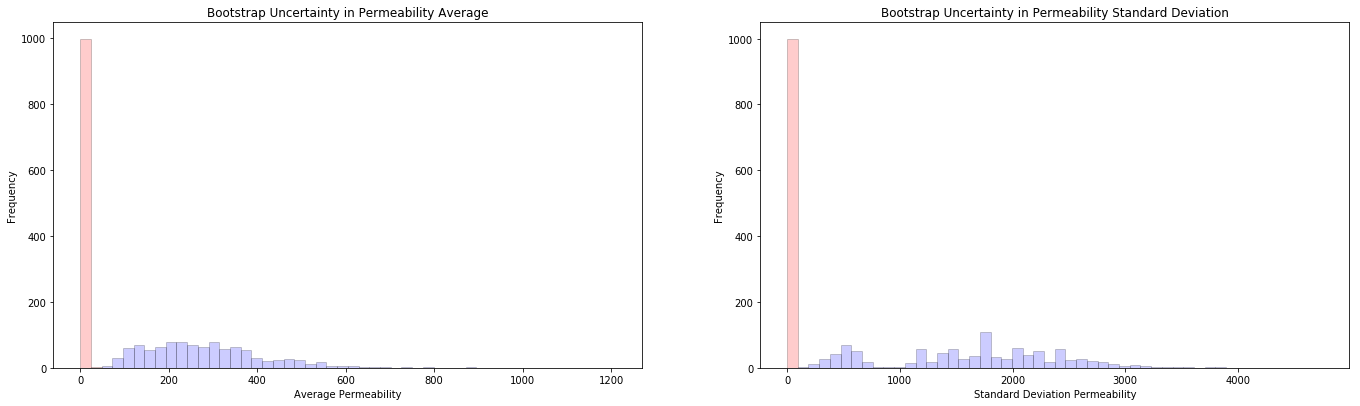

Summary Statistics for Bootstrap Sandstone Permeability Mean Realizations:
DescribeResult(nobs=1000, minmax=(57.54099706832588, 895.3328426673729), mean=278.3147446208373, variance=16048.553172856018, skewness=0.708619074185302, kurtosis=0.5408565290704384)
P10 124.871, P50 264.542, P90 460.466

Summary Statistics for Bootstrap Shale Permeability Mean Realizations:
DescribeResult(nobs=1000, minmax=(1.846595282220258, 30.3597837648232), mean=9.839375417981433, variance=12.043582442696996, skewness=0.6557004303030619, kurtosis=1.0593719243035116)
P10 5.663, P50 9.613, P90 14.472

Summary Statistics for Bootstrap Sandstone Permeability Standard Deviation Realizations:
DescribeResult(nobs=1000, minmax=(181.16072886031174, 3818.9427091199946), mean=1633.1803992854504, variance=585403.1184644189, skewness=-0.09899183110226853, kurtosis=-0.7696609422274849)
P10 492.053, P50 1730.054, P90 2602.994

Summary Statistics for Bootstrap Shale Permeability Standard Deviation Realizations:
DescribeRes

In [51]:
# do it by facies
L = 1000                                   # set the number of realizations
mean_sand = np.zeros(L); stdev_sand = np.zeros(L)    # declare arrays to hold the realizations of the statistics
mean_shale = np.zeros(L); stdev_shale = np.zeros(L)    # declare arrays to hold the realizations of the statistics
for l in range(0, L):                      # loop over realizations
    samples_sand = random.choices(raw_sandstone['Perm'].values, weights=raw_sandstone['Wts'].values,
                                  cum_weights=None, k=len(raw_sandstone))
    samples_shale = random.choices(raw_shale['Perm'].values, weights=raw_shale['Wts'].values,
                                  cum_weights=None, k=len(raw_shale))
    mean_sand[l] = np.average(samples_sand)
    mean_shale[l] = np.average(samples_shale)
    stdev_sand[l] = np.std(samples_sand)
    stdev_shale[l] = np.std(samples_shale)
    
plt.subplot(121)
hist_st(mean_sand,0.0,1210,False,False,50,None,
       'Average Permeability','Bootstrap Uncertainty in Permeability Average','blue')
hist_st(mean_shale,0.0,1210,False,False,50,None,
       'Average Permeability','Bootstrap Uncertainty in Permeability Average','red')

plt.subplot(122)
hist_st(stdev_sand,0.0,4750,False,False,50,None,
        'Standard Deviation Permeability','Bootstrap Uncertainty in Permeability Standard Deviation','blue')
hist_st(stdev_shale,0.0,4750,False,False,50,None,
        'Standard Deviation Permeability','Bootstrap Uncertainty in Permeability Standard Deviation','red')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()   
    
print('Summary Statistics for Bootstrap Sandstone Permeability Mean Realizations:')
print(stats.describe(mean_sand))
print('P10 ' + str(round(np.percentile(mean_sand,10),3)) 
      + ', P50 ' + str(round(np.percentile(mean_sand,50),3)) 
      + ', P90 ' + str(round(np.percentile(mean_sand,90),3))) 

print('')

print('Summary Statistics for Bootstrap Shale Permeability Mean Realizations:')
print(stats.describe(mean_shale))
print('P10 ' + str(round(np.percentile(mean_shale,10),3)) 
      + ', P50 ' + str(round(np.percentile(mean_shale,50),3)) 
      + ', P90 ' + str(round(np.percentile(mean_shale,90),3))) 

print('')

print('Summary Statistics for Bootstrap Sandstone Permeability Standard Deviation Realizations:')
print(stats.describe(stdev_sand))
print('P10 ' + str(round(np.percentile(stdev_sand,10),3)) 
      + ', P50 ' + str(round(np.percentile(stdev_sand,50),3)) 
      + ', P90 ' + str(round(np.percentile(stdev_sand,90),3))) 

print('')

print('Summary Statistics for Bootstrap Shale Permeability Standard Deviation Realizations:')
print(stats.describe(stdev_shale))
print('P10 ' + str(round(np.percentile(stdev_shale,10),3)) 
      + ', P50 ' + str(round(np.percentile(stdev_shale,50),3)) 
      + ', P90 ' + str(round(np.percentile(stdev_shale,90),3))) 

### 6. Estimated facies proportions and oil in place (Bootstrap)**

**6.1 Uncertainty Model for Facies Proportions**

Apply the bootstrap method to model facies proportions in the reservoir accounting for the spatial bias by taking cell decluster weights into account.

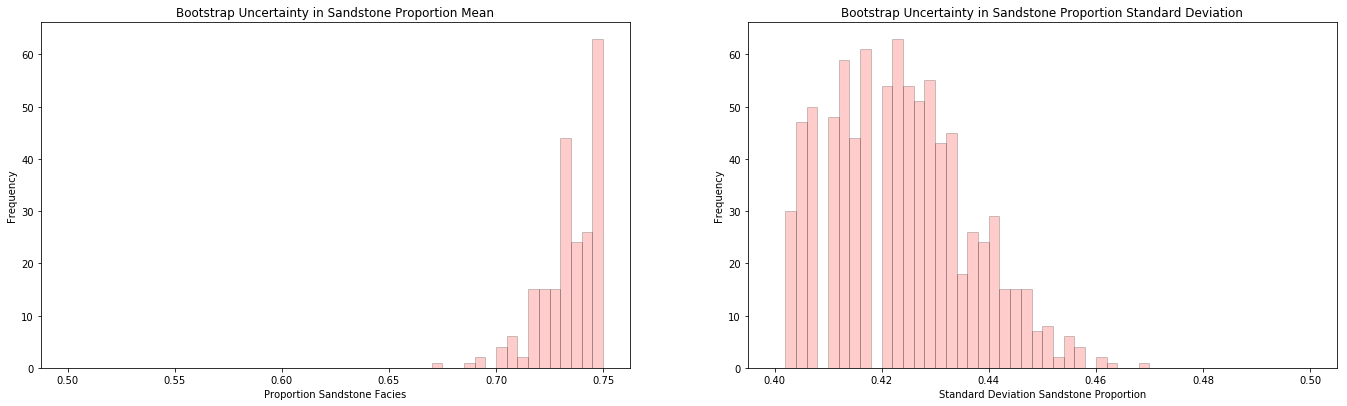

Summary Statistics for Bootstrap Facies Mean Realizations:
DescribeResult(nobs=1000, minmax=(0.6715867158671587, 0.8376383763837638), mean=0.7697859778597785, variance=0.0006419929549516565, skewness=-0.22594683297246712, kurtosis=0.055588415000995095)
P10 0.734, P50 0.771, P90 0.801

Summary Statistics for Bootstrap Facies Standard Deviation Realizations:
DescribeResult(nobs=1000, minmax=(0.36878222136233163, 0.4696360281515069), mean=0.41989563915623446, variance=0.000262089495319041, skewness=-0.16611108423938134, kurtosis=-0.028090092307080372)
P10 0.399, P50 0.42, P90 0.442


In [52]:
# assign DataFrame to raw or clean data (entire set)
df = raw_df
L = 1000                                   # set the number of realizations
mean = np.zeros(L); stdev = np.zeros(L)    # declare arrays to hold the realizations of the statistics
for l in range(0, L):                      # loop over realizations
    samples = random.choices(df['Facies'].values, weights=df['Wts'].values, cum_weights=None, k=len(df))
    mean[l] = np.average(samples)
    stdev[l] = np.std(samples)
    
plt.subplot(121)
GSLIB.hist_st(mean,0.5,0.75,False,False,50,None,
              'Proportion Sandstone Facies','Bootstrap Uncertainty in Sandstone Proportion Mean')

plt.subplot(122)
GSLIB.hist_st(stdev,0.4,0.5,False,False,50,None,
              'Standard Deviation Sandstone Proportion',
              'Bootstrap Uncertainty in Sandstone Proportion Standard Deviation')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()   
    
print('Summary Statistics for Bootstrap Facies Mean Realizations:')
print(stats.describe(mean))
print('P10 ' + str(round(np.percentile(mean,10),3)) + ', P50 ' + str(round(np.percentile(mean,50),3)) + ', P90 ' + str(round(np.percentile(mean,90),3))) 

print('\nSummary Statistics for Bootstrap Facies Standard Deviation Realizations:')
print(stats.describe(stdev))
print('P10 ' + str(round(np.percentile(stdev,10),3)) + ', P50 ' + str(round(np.percentile(stdev,50),3)) + ', P90 ' + str(round(np.percentile(stdev,90),3))) 


**6.2 Uncertainty Model for Oil in Place**

The oil saturation in the reservoir is assumed to be 0.9 and the thickness of the field is 20m. The dimensions of the area of interest are 1km x 1km which means the total volume is 1 x 1 x 0.2 = 0.2 cubic kilometers = 20,000,000 cubic meters. The porosity value will be sampled from the declustered porosity data.

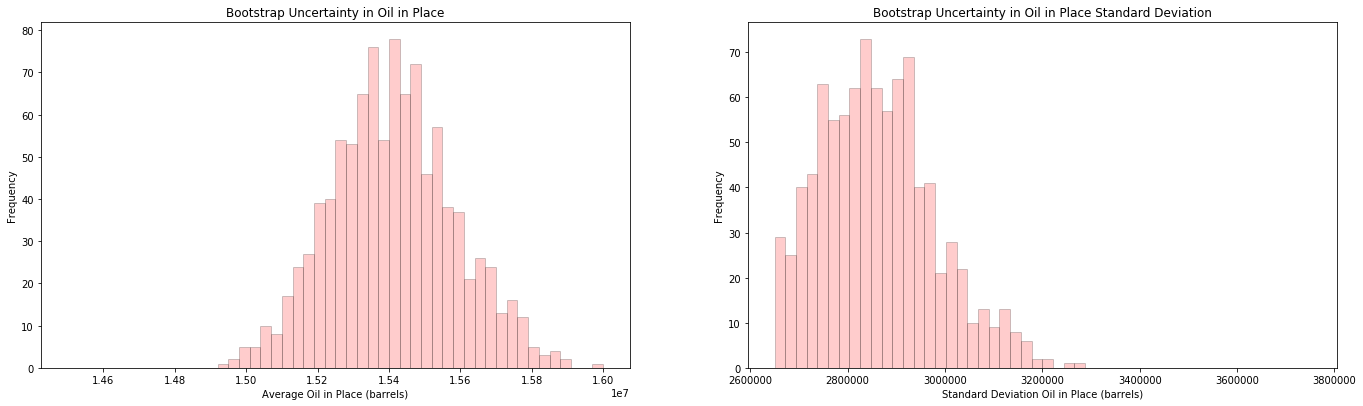

Summary Statistics for Bootstrap Oil in Place Mean Realizations:
DescribeResult(nobs=1000, minmax=(14925908.019157924, 15996875.692341568), mean=15410780.076186096, variance=30253554989.465317, skewness=0.14154252283917515, kurtosis=-0.11454426737514467)
P10 15192528.803, P50 15409295.192, P90 15644736.774

Summary Statistics for Bootstrap Oil in Place Standard Deviation Realizations:
DescribeResult(nobs=1000, minmax=(2431054.4839628376, 3269008.260140591), mean=2839020.1636787457, variance=18558902012.367607, skewness=0.08260906144927142, kurtosis=0.009985970393718624)
P10 2659994.227, P50 2837715.735, P90 3012038.677


In [54]:
# basically bootstrapping the overall porosity distribution weighted by declustered weights
L = 1000                                   # set the number of realizations
mean = np.zeros(L); stdev = np.zeros(L)    # declare arrays to hold the realizations of the statistics
for l in range(0, L):                      # loop over realizations
    samples = random.choices(df['Porosity'].values, weights=df['Wts'].values, cum_weights=None, k=len(df))
    for i in range(0,len(df)):
        samples[i] = samples[i]*20000000*0.9*6.29
    mean[l] = np.average(samples)
    stdev[l] = np.std(samples)
    
plt.subplot(121)
GSLIB.hist_st(mean,14500000,16000000,False,False,50,None,
              'Average Oil in Place (barrels)',
              'Bootstrap Uncertainty in Oil in Place')

plt.subplot(122)
GSLIB.hist_st(stdev,2650000,3750000,False,False,50,None,
              'Standard Deviation Oil in Place (barrels)',
              'Bootstrap Uncertainty in Oil in Place Standard Deviation')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()   
    
print('Summary Statistics for Bootstrap Oil in Place Mean Realizations:')
print(stats.describe(mean))
print('P10 ' + str(round(np.percentile(mean,10),3)) + ', P50 ' + str(round(np.percentile(mean,50),3)) + ', P90 ' + str(round(np.percentile(mean,90),3))) 

print('\nSummary Statistics for Bootstrap Oil in Place Standard Deviation Realizations:')
print(stats.describe(stdev))
print('P10 ' + str(round(np.percentile(stdev,10),3)) + ', P50 ' + str(round(np.percentile(stdev,50),3)) + ', P90 ' + str(round(np.percentile(stdev,90),3))) 


### 7. Assessed impact of 10 additional wells on the uncertainty model**

When 10 additional wells are considered, we assume that the 10 additional wells are from the same distribution as our prior 271 wells. Therefore the addition of 10 wells represents an increase of only about 4% of information. We simulate this impact by increasing the number of samples drawn during bootstrapping by 10. The change in the predicted standard deviation for the oil in place estimate was on the order of 0.01% and therefore deemed to be negligible.

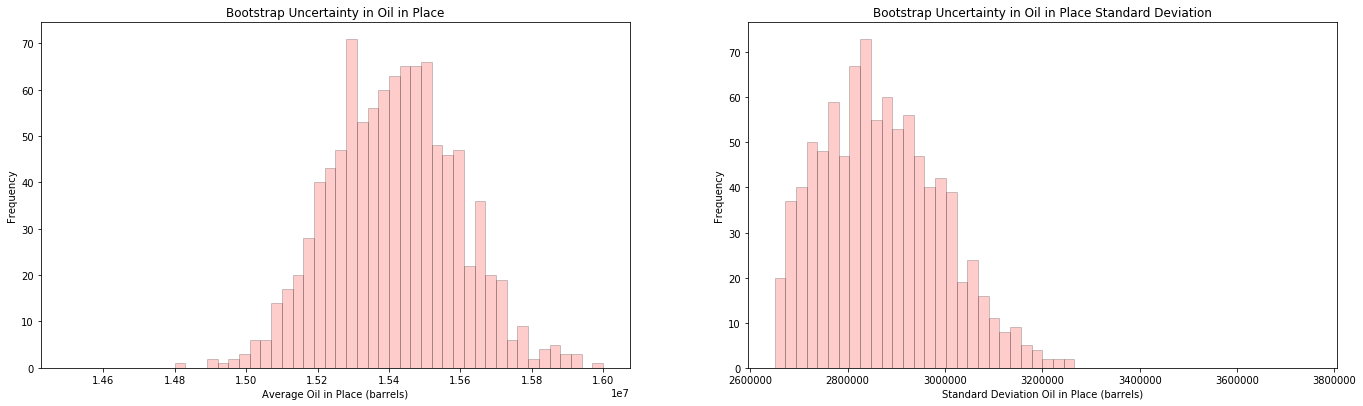

Summary Statistics for Bootstrap Oil in Place Mean Realizations:
DescribeResult(nobs=1000, minmax=(14824212.33011951, 15991988.579084767), mean=15413579.204545785, variance=31699498696.288414, skewness=0.07295628712731049, kurtosis=-0.02974386821705366)
P10 15190715.102, P50 15415144.089, P90 15645707.666

Summary Statistics for Bootstrap Oil in Place Standard Deviation Realizations:
DescribeResult(nobs=1000, minmax=(2461842.18009527, 3252550.21767492), mean=2851341.2607962294, variance=18835742398.003445, skewness=0.07618759074879797, kurtosis=-0.16549549934239183)
P10 2681700.492, P50 2846334.544, P90 3028008.401


In [55]:
# basically bootstrapping the overall porosity distribution weighted by declustered weights
L = 1000                                   # set the number of realizations
mean = np.zeros(L); stdev = np.zeros(L)    # declare arrays to hold the realizations of the statistics
for l in range(0, L):                      # loop over realizations
    samples = random.choices(df['Porosity'].values, weights=df['Wts'].values, cum_weights=None, k=len(df)+10)
    for i in range(0,len(df)+10):
        samples[i] = samples[i]*20000000*0.9*6.29
    mean[l] = np.average(samples)
    stdev[l] = np.std(samples)
    
plt.subplot(121)
GSLIB.hist_st(mean,14500000,16000000,False,False,50,None,
              'Average Oil in Place (barrels)',
              'Bootstrap Uncertainty in Oil in Place')

plt.subplot(122)
GSLIB.hist_st(stdev,2650000,3750000,False,False,50,None,
              'Standard Deviation Oil in Place (barrels)',
              'Bootstrap Uncertainty in Oil in Place Standard Deviation')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()   
    
print('Summary Statistics for Bootstrap Oil in Place Mean Realizations:')
print(stats.describe(mean))
print('P10 ' + str(round(np.percentile(mean,10),3)) + ', P50 ' + str(round(np.percentile(mean,50),3)) + ', P90 ' + str(round(np.percentile(mean,90),3))) 

print('\nSummary Statistics for Bootstrap Oil in Place Standard Deviation Realizations:')
print(stats.describe(stdev))
print('P10 ' + str(round(np.percentile(stdev,10),3)) + ', P50 ' + str(round(np.percentile(stdev,50),3)) + ', P90 ' + str(round(np.percentile(stdev,90),3))) 


### 8.Conclusions

Based on the data and analyses done, the reservoir was found to be extremely heterogeneous with a reservoir-wide coeﬃcient of variation of 2.00 as well as a Dykstra-Parson’s coeﬃcient of 0.883. This information is crucial to constraining the interpretation of the depositional environment. It was also found that the coeﬃcient of variation is sensitive to outliers in the dataset due to the strong dependence on the sample variance. Future work for assessing the heterogeneity of the reservoir should include dynamic measures including ﬂow simulation. Furthermore, spatial declustering was performed on the data set and new summary statistics were presented. Hypothesis testing of the facies suggest statistically diﬀerent values for porosity and permeability between the two facies (sandstone and shale). New analyses suggest a decrease in the average reservoir porosity and permeability from earlier predictions. The estimated oil in place is approximately 15.27 million of barrels, but we note that this is an early estimate with high uncertainty. The impact of drilling 10 additional wells is negligible in order to decrease the uncertainty.
